<a href="https://colab.research.google.com/github/Thrishasivasakthi/python/blob/main/tbconference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
import shutil
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
!pip install tensorflow_gan
import tensorflow_gan as tfgan
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install -q Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sthrisha","key":"61024a08a72e9ab0defae43745b9d465"}'}

In [ ]:
! mkdir ~/.kaggle


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

 99% 657M/663M [00:03<00:00, 193MB/s]
100% 663M/663M [00:04<00:00, 172MB/s]


In [ ]:
! unzip dataset.zip

Archive:  dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1009.png  
  inflating: TB_Chest_Radiography_

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set the path to your dataset
dataset_path = '/content/TB_Chest_Radiography_Database'

# Create train and test directories
train_path = '/content/train'
test_path = '/content/test'
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Loop through each class (Normal and Tuberculosis)
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # List all images in the class
        images = [img for img in os.listdir(class_path) if img.endswith('.png')]

        # Split the images into train and test sets
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Move images to the respective directories
        for img in train_images:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(train_path, class_name, img)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)

        for img in test_images:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(test_path, class_name, img)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)


FileNotFoundError: ignored

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directories for training and test sets
train_base_directory = '/content/train'
test_base_directory = '/content/test'

# Image size
image_size = (224, 224)

# Create an ImageDataGenerator for data augmentation (if needed)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Batch size
batch_size = 32

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_base_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  #  (Normal and Tuberculosis)
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_base_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # (Normal and Tuberculosis)
)

#  Preprocess the first batch of training data
images, labels = train_generator.next()
# Assuming train_generator is your data generator
for batch in train_generator:
    # Get the input data (features) from the batch
    input_data = batch[0]

    # Print the shape of the input data
    print("Shape of input data:", input_data.shape)

    # Assuming the labels are also present in the batch, you can check their shape too
    labels = batch[1]
    print("Shape of labels:", labels.shape)

    # Break the loop after printing the shape of the first batch
    break




FileNotFoundError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Set your data directories
train_dir = '/content/train'
test_dir = '/content/test'

# Image size
image_size = (224, 224)
batch_size = 32

# Use data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# the validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build the transfer learning model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # (Normal and Tuberculosis)
])

# Compile the model with learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 1
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
105/105 [==============================] - 701s 7s/step - loss: 0.2221 - accuracy: 0.9187 - val_loss: 0.0946 - val_accuracy: 0.9548


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
model_save_path = '/content/gdrive/MyDrive/Colab_Notebooks'
#model.save(model_save_path)


In [ ]:
# Load the TL model from Google Drive
loaded_tl_model = tf.keras.models.load_model(model_save_path)


In [ ]:
# Assuming train_generator is your training data generator
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)


NameError: ignored

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Evaluate the TL model on the test data
evaluation_result = loaded_tl_model.evaluate(test_generator)
print("Evaluation Result:", evaluation_result)


27/27 [==============================] - 144s 5s/step - loss: 0.0946 - accuracy: 0.9548
Evaluation Result: [0.09455952048301697, 0.9547619223594666]


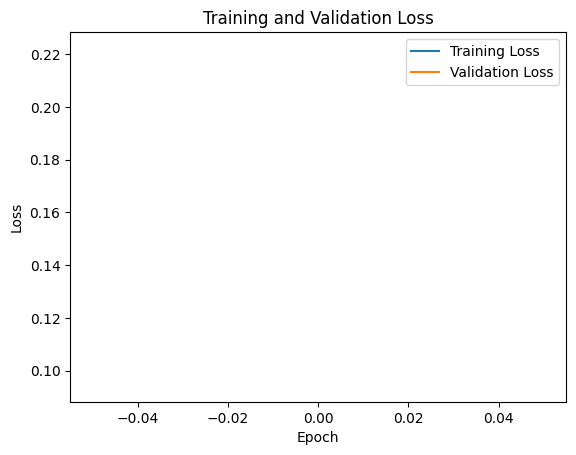

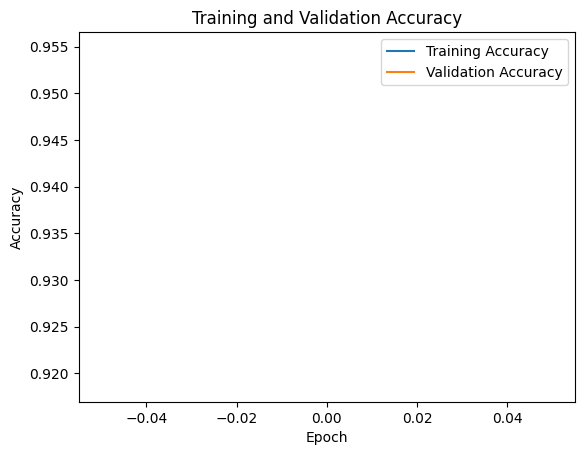

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss_plot.png')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy_plot.png')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to an image in the test set
image_path = '/content/test/Tuberculosis/Tuberculosis-113.png'
#image_path = '/content/test/Normal/Normal-101.png'
# Load the image with target size
img = image.load_img(image_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the model's expected shape
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (scaling, etc.)
img_array = img_array / 255.0  # Rescale to [0, 1]

# Make predictions
predictions = loaded_tl_model.predict(img_array)
print("prediction probabilities:", predictions)


# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

threshold = 0.0
predicted_class = (predictions > threshold).astype(int)
print("predicted class index:", predicted_class)

# Display the result
if predicted_class == 0:
    print("Prediction: Normal")
else:
    print("Prediction: Tuberculosis")


1/1 [==============================] - 1s 1s/step
prediction probabilities: [[0.15018508]]
predicted class index: [[1]]
Prediction: Tuberculosis


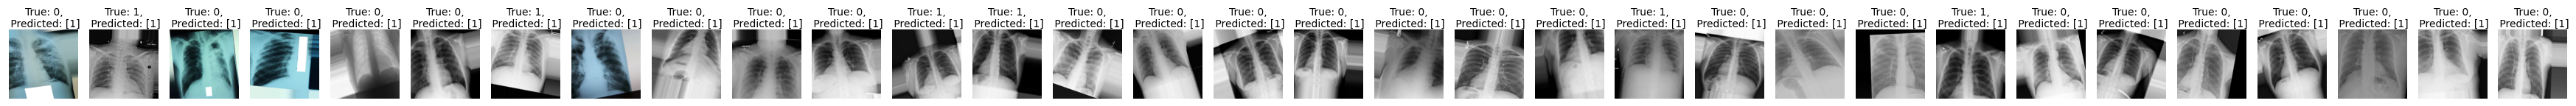

In [ ]:
import matplotlib.pyplot as plt

# Visualize the images along with their true and predicted labels
plt.figure(figsize=(35, 25))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)  # Adjust subplot parameters for batch size
    plt.imshow(images[i])

    # Handle single-item array for labels
    true_label = int(labels[0]) if len(labels) == 1 else int(labels[i])
    predicted_label = predicted_class[0] if len(predicted_class) == 1 else predicted_class[i]

    title = f'True: {true_label},\n Predicted: {predicted_label}'
    plt.title(title, fontsize=10, pad=2)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Function to define the generator
def define_generator(latent_dim, image_size):
    noise_input = layers.Input(shape=(latent_dim,))

    # Generator architecture
    gen = layers.Dense(128 * (image_size[0] // 4) * (image_size[1] // 4), activation="relu")(noise_input)
    gen = layers.Reshape((image_size[0] // 4, image_size[1] // 4, 128))(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation="relu")(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation="relu")(gen)
    gen = layers.BatchNormalization()(gen)
    gen_output = layers.Conv2DTranspose(3, (7, 7), activation="tanh", padding="same")(gen)

    generator = tf.keras.models.Model(inputs=[noise_input], outputs=gen_output)
    return generator


# Function to define the discriminator
def define_discriminator(input_shape):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Function to define the GAN model
def define_gan(generator, discriminator, latent_dim):
    discriminator.trainable = False
    noise_input = layers.Input(shape=(latent_dim,))
    gen_samples = generator(noise_input)
    validity = discriminator(gen_samples)

    gan_model = tf.keras.models.Model(inputs=noise_input, outputs=validity)
    gan_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    return gan_model


# Create instances of the generator, discriminator, and GAN model
latent_dim = 100
image_size = (224, 224, 3)
generator = define_generator(latent_dim, image_size)
discriminator = define_discriminator(image_size)
gan_model = define_gan(generator, discriminator, latent_dim)

# Assuming you have a dataset and data generators defined (train_generator, test_generator)
num_epochs = 1
batch_size = 32
num_batches_per_epoch = 10

# Real labels for training the GAN
real_labels = np.ones((batch_size, 1))


# Training loop
for epoch in range(num_epochs):
    for batch in range(num_batches_per_epoch):
        # Train discriminator on real samples
        real_samples, _ = train_generator.next()
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)

        # Train discriminator on fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))

        # Train GAN
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan_model.train_on_batch(noise, real_labels)
        # Print progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch + 1}/{num_batches_per_epoch}, "
              f"D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")


1/1 [==============================] - 10s 10s/step
Epoch 1/1, Batch 1/10, D Loss Real: 0.6019911170005798, D Loss Fake: 0.7014056444168091, G Loss: 0.18674609065055847
1/1 [==============================] - 7s 7s/step
Epoch 1/1, Batch 2/10, D Loss Real: 0.007536750286817551, D Loss Fake: 0.6886544227600098, G Loss: 0.06702692806720734
1/1 [==============================] - 10s 10s/step
Epoch 1/1, Batch 3/10, D Loss Real: 0.0009944045450538397, D Loss Fake: 0.6714228987693787, G Loss: 0.056644096970558167
1/1 [==============================] - 7s 7s/step
Epoch 1/1, Batch 4/10, D Loss Real: 0.0003945609787479043, D Loss Fake: 0.6338464021682739, G Loss: 0.051264338195323944
1/1 [==============================] - 8s 8s/step
Epoch 1/1, Batch 5/10, D Loss Real: 0.0006915066624060273, D Loss Fake: 0.5916507244110107, G Loss: 0.052278708666563034
1/1 [==============================] - 9s 9s/step
Epoch 1/1, Batch 6/10, D Loss Real: 0.0006592170102521777, D Loss Fake: 0.5465471148490906, G Los

1/1 [==============================] - 1s 661ms/step


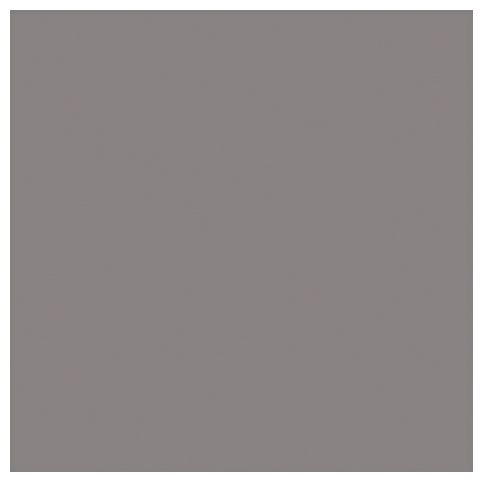

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and visualize samples
def generate_samples(generator, latent_dim, num_samples=5):
    # Generate random noise
    noise = np.random.normal(0, 1, (num_samples, latent_dim))

    # Generate samples using the generator
    generated_images = generator.predict(noise)

    # Rescale pixel values to the range [0, 255]
    generated_images = 0.5 * generated_images + 0.5

    # Plot the generated images
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Generate and visualize samples
num_generated_samples = 1
generate_samples(generator, latent_dim, num_generated_samples)


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model



from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

def define_autoencoder(latent_dim, image_size):
    # Encoder
    input_img = Input(shape=image_size)  # Assuming (height, width, channels)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(latent_dim, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Assuming 3 channels

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error for image reconstruction
    return autoencoder



# Assuming you have a dataset and data generators defined (train_generator, test_generator)
latent_dim = 100
image_size = (224, 224, 3)
autoencoder_epochs = 10
autoencoder_batch_size = 32

# Create instances of the generator, autoencoder, and GAN model
generator = define_generator(latent_dim, image_size)
autoencoder = define_autoencoder(latent_dim, image_size)

# Assuming you have a dataset and data generators defined (train_generator, test_generator)
num_epochs = 1
batch_size = 32
num_batches_per_epoch = 10

# Real labels for training the GAN
real_labels = np.ones((batch_size, 1))

# Generate latent representations using the trained GAN generator
latent_representations = []
for batch in range(num_batches_per_epoch):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Generate noise similar to GAN training
    generated_samples = generator.predict(noise)
    latent_representations.append(generated_samples)

# Concatenate the latent representations into a single array
latent_representations = np.concatenate(latent_representations, axis=0)

# Train the autoencoder using the generated latent representations
autoencoder.fit(latent_representations, latent_representations, epochs=autoencoder_epochs, batch_size=autoencoder_batch_size, shuffle=True)


1/1 [==============================] - 9s 9s/step
Epoch 1/10
10/10 [==============================] - 243s 24s/step - loss: 0.1882
Epoch 2/10
10/10 [==============================] - 246s 25s/step - loss: 0.0041
Epoch 3/10
10/10 [==============================] - 240s 24s/step - loss: 7.7288e-06
Epoch 4/10
10/10 [==============================] - 240s 24s/step - loss: 6.8942e-06
Epoch 5/10
10/10 [==============================] - 238s 24s/step - loss: 6.8488e-06
Epoch 6/10
10/10 [==============================] - 240s 24s/step - loss: 6.8402e-06
Epoch 7/10
10/10 [==============================] - 238s 24s/step - loss: 6.8377e-06
Epoch 8/10
10/10 [==============================] - 241s 24s/step - loss: 6.8369e-06
Epoch 9/10
10/10 [==============================] - 238s 24s/step - loss: 6.8366e-06
Epoch 10/10
10/10 [==============================] - 243s 24s/step - loss: 6.8365e-06


1/1 [==============================] - 0s 250ms/step


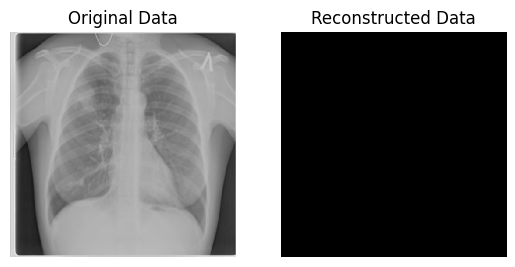

In [ ]:
from keras.preprocessing import image

# Path to the test image
image_path = '/content/test/Tuberculosis/Tuberculosis-113.png'

# Load the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension

# Perform prediction using the autoencoder
reconstructed_data = autoencoder.predict(img_array)

# Visualize the original and reconstructed data
import matplotlib.pyplot as plt

# Display the original data
plt.subplot(1, 2, 1)
plt.title('Original Data')
plt.imshow(img_array[0].astype('uint8'))  # Assuming 3D data (height, width, channels)
plt.axis('off')

# Display the reconstructed data
plt.subplot(1, 2, 2)
plt.title('Reconstructed Data')
plt.imshow(reconstructed_data[0].astype('uint8'))  # Assuming 3D data (height, width, channels)
plt.axis('off')

plt.show()


1/1 [==============================] - 14s 14s/step
Epoch 1/1, Batch 1/10, D Loss Real: 0.0002023179258685559, D Loss Fake: 0.07155965268611908, G Loss: 0.015018864534795284
1/1 [==============================] - 7s 7s/step
Epoch 1/1, Batch 2/10, D Loss Real: 0.0011757975444197655, D Loss Fake: 0.045067448168992996, G Loss: 0.00493466854095459
1/1 [==============================] - 10s 10s/step
Epoch 1/1, Batch 3/10, D Loss Real: 0.00025188399013131857, D Loss Fake: 0.030536513775587082, G Loss: 0.002910800278186798
1/1 [==============================] - 7s 7s/step
Epoch 1/1, Batch 4/10, D Loss Real: 0.00016660481924191117, D Loss Fake: 0.022100180387496948, G Loss: 0.0020016892813146114
1/1 [==============================] - 9s 9s/step
Epoch 1/1, Batch 5/10, D Loss Real: 0.00034478073939681053, D Loss Fake: 0.0168472770601511, G Loss: 0.0012992075644433498
1/1 [==============================] - 9s 9s/step
Epoch 1/1, Batch 6/10, D Loss Real: 0.00029695482226088643, D Loss Fake: 0.01335

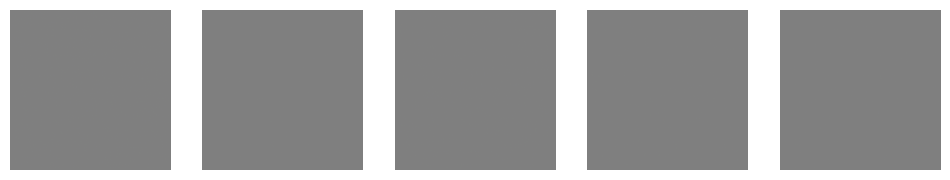

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for batch in range(num_batches_per_epoch):
        # Train discriminator on real samples
        real_samples, _ = train_generator.next()
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)

        # Train discriminator on fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))

        # Train GAN
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan_model.train_on_batch(noise, real_labels)

        # Print progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch + 1}/{num_batches_per_epoch}, "
              f"D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

# Generate and visualize samples
num_generated_samples = 5
generate_samples(generator, latent_dim, num_generated_samples)
